## Table of Contents
* [0. Setup](#setup)
* [1. Information on histone marks](#histone)
* [2. Absolute signal](#abs)
    * [2.1 Heatmap](#abs_hm)
* [3. Fold change](#fc)
    * [3.1 Heatmap](#fc_hm)
    * [3.2 Boxplot](#fc_bp)
        * [3.2.1 Statistical significance](#fc_ss)

## 0. Setup <a class="anchor" id="setup"></a>

In [3]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style('ticks')
%config InlineBackend.figure_format='retina'

from statannotations.Annotator import Annotator

import pickle
import pyBigWig

import scanpy as sc

import pathlib

import torch

import tqdm.auto as tqdm

import chromatinhd as chd

Set up folder paths and load slice topologies. 

In [4]:
working_directory = os.getcwd()
encode_folder = chd.get_output() / "data" / "encode2"
bw_folder = encode_folder / "immune"
prediction_path = chd.get_output() / "prediction_likelihood/pbmc10k/10k10k/leiden_0.1/v9_128-64-32"
scores_dir = prediction_path / "scoring" / "significant_up"
scores_file = scores_dir / "slicetopologies.csv"
slicetopologies = pd.read_csv(scores_file, index_col = 0)

In [5]:
clusters = ['NK', 'Monocytes', 'CD4 T', 'B', 'CD8 T']
all_slicetopologies_oi = slicetopologies.query("cluster in @clusters")
all_slicetopologies_oi.index.name = "slice_ix"

In [6]:
analysis_folder = prediction_path / "encode_marks"
analysis_folder.mkdir(exist_ok = True, parents = True)

In [7]:
files = pd.read_csv(bw_folder / "files.csv", index_col = 0)
files["target"] = files["Experiment target"].str.split("-").str[0]

# DNA methylation will have as "Experiment target" = NA, but we change it here to DNAme for consistency downstream
files.loc[pd.isnull(files["target"]), "target"] = "DNAme"

In [8]:
biosamples_oi = pd.DataFrame([
    ["naive thymus-derived CD4-positive, alpha-beta T cell", "CD4 T"],
    ["naive thymus-derived CD8-positive, alpha-beta T cell", "CD8 T"],
    ["CD14-positive monocyte", "Monocytes"],
    ["naive B cell", "B"],
    ["B cell", "B"],
    ["immature natural killer cell", "NK"],
    ["natural killer cell", "NK"],
    ["dendritic cell", "cDCs"]
], columns = ["Biosample term name", "cluster"])
clusters_info = pd.DataFrame({"cluster":biosamples_oi["cluster"].unique()}).set_index("cluster")

In [9]:
files_oi = pd.merge(files, biosamples_oi)

clusters_oi = clusters_info.loc[['NK', 'Monocytes', 'CD4 T', 'B', 'CD8 T']]
files_oi = files_oi.query("cluster in @clusters_oi.index")

targets = ["DNAme", "H3K27ac", "H3K27me3", "H3K36me3", "H3K4me1", "H3K4me3", "H3K9me3"]
files_oi = files_oi.query("target in @targets")

files_oi = files_oi.copy()
files_oi["file"] = [pyBigWig.open(str(bw_folder / file["filename"])) for _, file in files_oi.iterrows()]
files_oi.index.name = "file_ix"

files_oi = files_oi.sort_values("cluster")

## 1. Information on histone marks <a class="anchor" id="histone"></a>

- H3K27ac - This modification is also associated with **active gene transcription**. It is often found near enhancer regions, which are regulatory regions that can increase gene expression.
- H3K27me3 - This modification is associated with **gene repression**. It is often found at regions of chromatin that are tightly packed and inaccessible to transcriptional machinery.
- H3K36me3 - This modification is associated with **gene expression** and is often found at the bodies of actively transcribed genes. It may help recruit proteins that are involved in elongation of the transcript during transcription. It is often correlated with high methylation in gene bodies (https://www.embopress.org/doi/full/10.15252/embj.201796812) and because it promotes DNA methylation, it is likely involved in avoiding aberrant transcription from intragenic transcription start sites.
- H3K4me1 - This modification is associated with **enhancer regions** and is thought to help stabilize their structure.
- H3K4me3 - This modification is typically associated with **active gene transcription**. It is often found at the promoter regions of genes, where it can help recruit transcription factors and other proteins that initiate transcription.
- H3K9me3 - This modification is also associated with **gene repression**. It is often found at regions of chromatin that are densely packed and transcriptionally inactive.

## 2. Absolute signal <a class="anchor" id="abs"></a>

Here we will look at the absolute signal values of the slices for each histone mark.
We want to answer the question: how are different shapes (or "topologies") of differential DNA accessibility associated with different histone marks?

The simplest way to answer this question is to take all the regions that are differential in a particular cell type, and look at the average signal for a chromatin mark in the particular region in the samples from the particular cell type. In other words, we will average both across a whole region and across all samples.

In [8]:
all_signals_slices = {}
# for each slice
for slice_ix, slicetopology in tqdm.tqdm(all_slicetopologies_oi.iterrows(), total = len(all_slicetopologies_oi)):
    signals = []
    file_ixs = []

    # select only the celltypes in which the slice was differential
    for file_ix, file in files_oi.loc[files_oi["cluster"] == slicetopology["cluster"]]["file"].items():
        signals.append(np.array(file.values(slicetopology.chr, slicetopology.start, slicetopology.end)))
        file_ixs.append(file_ix)

    # stack the signal from the different files (i.e. samples) and then calculate the mean for each target (=mark)
    signals = pd.DataFrame(np.stack(signals), index = file_ixs)
    signals.index = files_oi.loc[file_ixs, "target"]
    all_signals_slices[slice_ix] = signals

  0%|          | 0/20942 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [74]:
pickle.dump(all_signals_slices, (analysis_folder / "all_signals_slices.pkl").open("wb"))

Load in the data again

In [10]:
all_signals_slices = pickle.load((analysis_folder / "all_signals_slices.pkl").open("rb"))

Take the mean for each 

In [11]:
all_signal_topologies = []
for slice_ix, slicetopology in tqdm.tqdm(all_slicetopologies_oi.iterrows(), total = len(all_slicetopologies_oi)):
    signals = all_signals_slices[slice_ix].groupby(level = 0).mean().mean(1)
    all_signal_topologies.append(pd.DataFrame({"slice_ix":slice_ix, "signal":signals.values, "target":signals.index}))
all_signal_topologies = pd.concat(all_signal_topologies)
all_signal_topologies.replace([np.inf, -np.inf], np.nan, inplace=True)

  0%|          | 0/20942 [00:00<?, ?it/s]

In [12]:
all_signal_topologies_mean = all_signal_topologies.join(all_slicetopologies_oi[["type"]], on = "slice_ix").groupby(["type", "target"])["signal"].mean().unstack()

In [13]:
# do max normalization for each mark
all_signal_topologies_mean_norm = all_signal_topologies_mean / all_signal_topologies_mean.values.max(0)

### 2.1 Heatmap <a class="anchor" id="abs_hm"></a>

<AxesSubplot:xlabel='type', ylabel='target'>

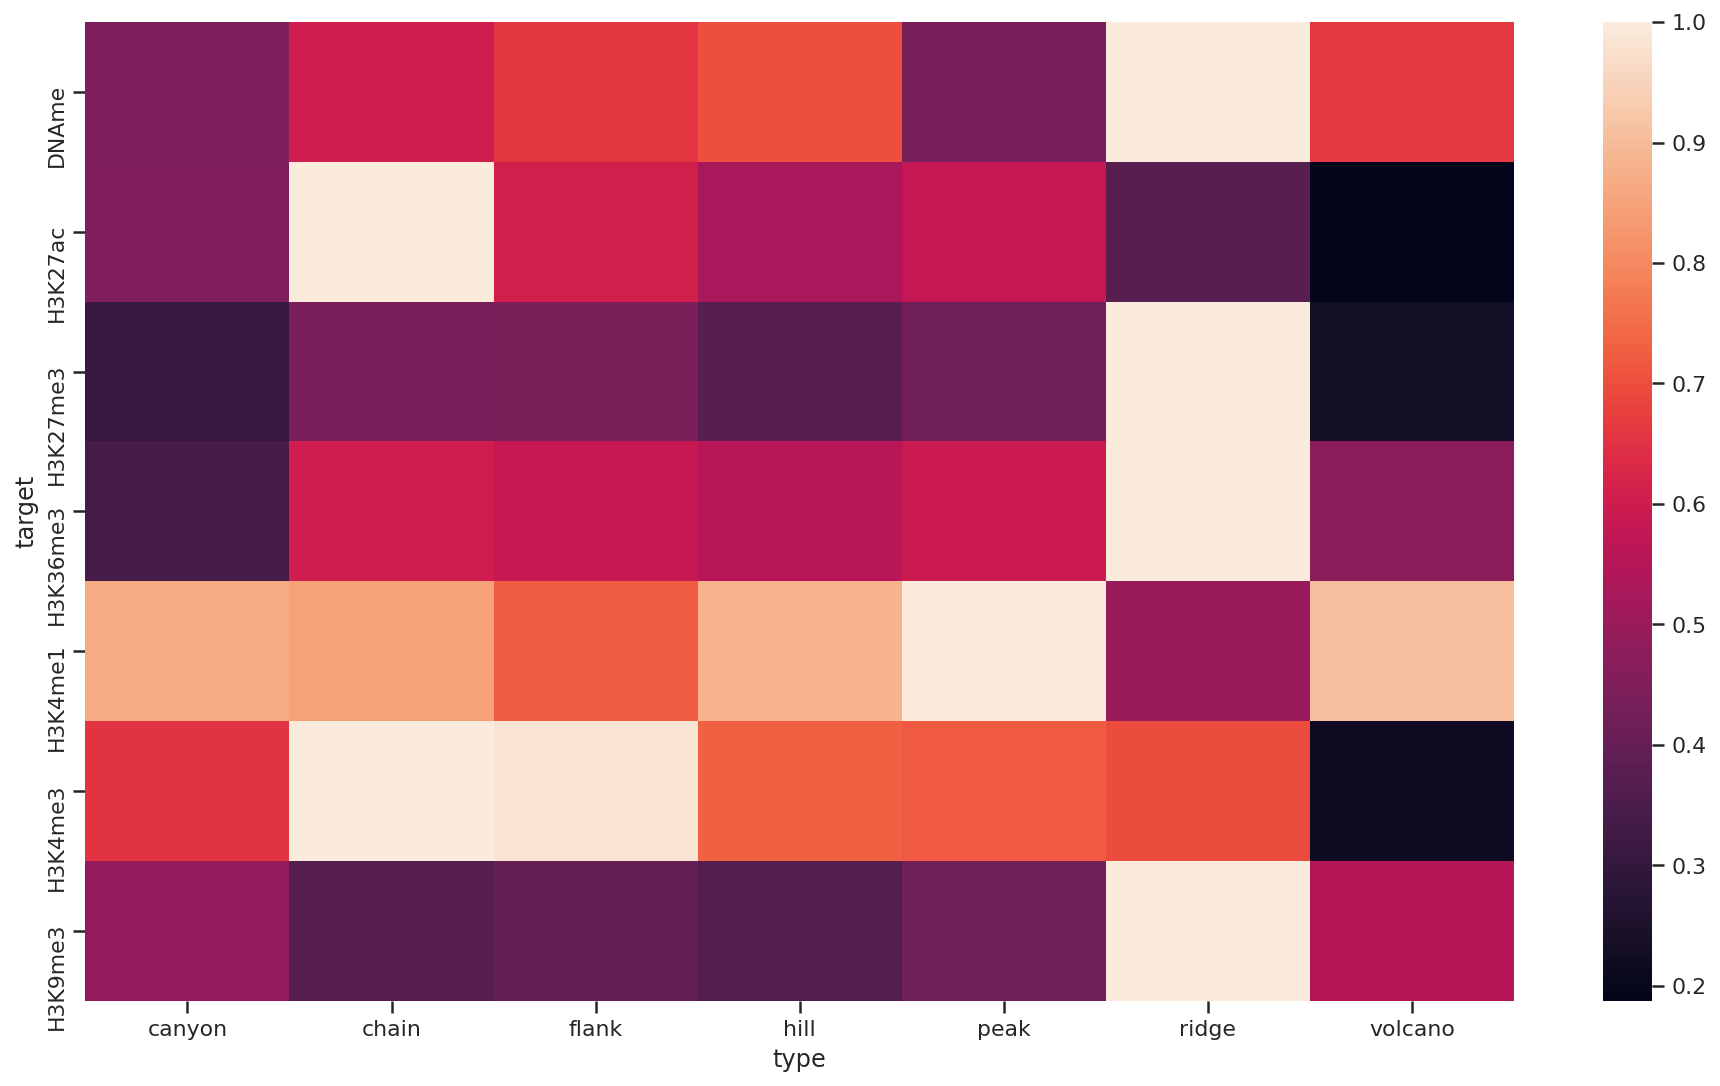

In [14]:
sns.heatmap(all_signal_topologies_mean_norm.T)

We can see that on average there is a clear link between some slice topologies and histone marks. For example, ridges are clearly linked with H3K36me3 and DNA methylation, probably because they are often found in highly expressed genes, and there is therefore a need to shut off aberrant transcription start sites (see e.g. https://www.embopress.org/doi/full/10.15252/embj.201796812). 

## 3. Fold change <a class="anchor" id="fc"></a>

Now we will look at the fold change in the signal for each slice. In other words, how much higher is a mark in cell type X versus the same mark in the same region for all other cell types?

For this, we will extract the signal for each slice across all cell types and compare the average signal of cell type X within a slice with the everage for all other cell types.

In [13]:
all_slicetopologies_oi = slicetopologies.query("cluster in @clusters") # select all regions
all_slicetopologies_oi.index.name = "slice_ix"

In [29]:
all_signals_slices_ = {}

# for each slice
for slice_ix, slicetopology in tqdm.tqdm(all_slicetopologies_oi.iterrows(), total = len(all_slicetopologies_oi)):
    signals = []
    file_ixs = []

    # select all celltypes
    for file_ix, file in files_oi["file"].items():
        signals.append(np.array(file.values(slicetopology.chr, slicetopology.start, slicetopology.end)))
        file_ixs.append(file_ix)

    # stack the signal from the different files (i.e. samples)
    signals = pd.DataFrame(np.stack(signals), index = [files_oi.loc[file_ixs,"target"],files_oi.loc[file_ixs,"cluster"]]) 
    all_signals_slices_[slice_ix] = signals

  0%|          | 0/20942 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
pickle.dump(all_signals_slices_, (analysis_folder / "all_signals_slices_.pkl").open("wb"))

Load in the data again

In [15]:
all_signals_slices_ = pickle.load((analysis_folder / "all_signals_slices_.pkl").open("rb"))

Take the mean for each 

In [16]:
# Dictionary of the original cluster where the slice was found
all_og_cluster_dict = all_slicetopologies_oi["cluster"]
all_og_cluster_dict = all_og_cluster_dict.rename("og_cluster")
all_og_cluster_dict = all_og_cluster_dict.to_dict()

In [17]:
all_signal_topologies_ = []
for slice_ix, slicetopology in tqdm.tqdm(all_slicetopologies_oi.iterrows(), total = len(all_slicetopologies_oi)):
    # For each slice, take the average signal of each cell type 
    signals = all_signals_slices_[slice_ix].groupby(["target", "cluster"]).mean().mean(1)
    signals.name = "signal"
    signals = signals.to_frame()
    signals.reset_index(inplace=True)
    
    # (Mask column to calculate fold change)
    signals["is_og_cluster"] = signals["cluster"] == all_og_cluster_dict[slice_ix]
    
    all_signal_topologies_.append(pd.DataFrame({"slice_ix":slice_ix, "signal":signals.signal, "target":signals.target, "cluster": signals.cluster, "is_og_cluster": signals.is_og_cluster}))
all_signal_topologies_ = pd.concat(all_signal_topologies_)

  0%|          | 0/20942 [00:00<?, ?it/s]

In [18]:
# Average signal of the original cell type
all_signal_topologies_og = all_signal_topologies_.loc[all_signal_topologies_["is_og_cluster"]][["slice_ix", "target", "signal"]].set_index(["slice_ix", "target"])
# Average signal in all other cell types
all_signal_topologies_mean_ = all_signal_topologies_.loc[~all_signal_topologies_["is_og_cluster"]][["slice_ix", "target", "signal"]].groupby(["slice_ix", "target"]).mean()

all_signal_topologies_fold_change = all_signal_topologies_og.join(all_signal_topologies_mean_, lsuffix='_og', rsuffix="_mean")
all_signal_topologies_fold_change["fc"] = all_signal_topologies_fold_change["signal_og"]/all_signal_topologies_fold_change["signal_mean"]
all_signal_topologies_fold_change["log_fc"] = np.log(all_signal_topologies_fold_change["fc"])
all_signal_topologies_fold_change.reset_index(inplace=True)
all_signal_topologies_fold_change.replace([np.inf, -np.inf], np.nan, inplace=True)
#display(all_signal_topologies_fold_change)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 3.1 Heatmap <a class="anchor" id="fc_hm"></a>

<AxesSubplot:xlabel='type', ylabel='target'>

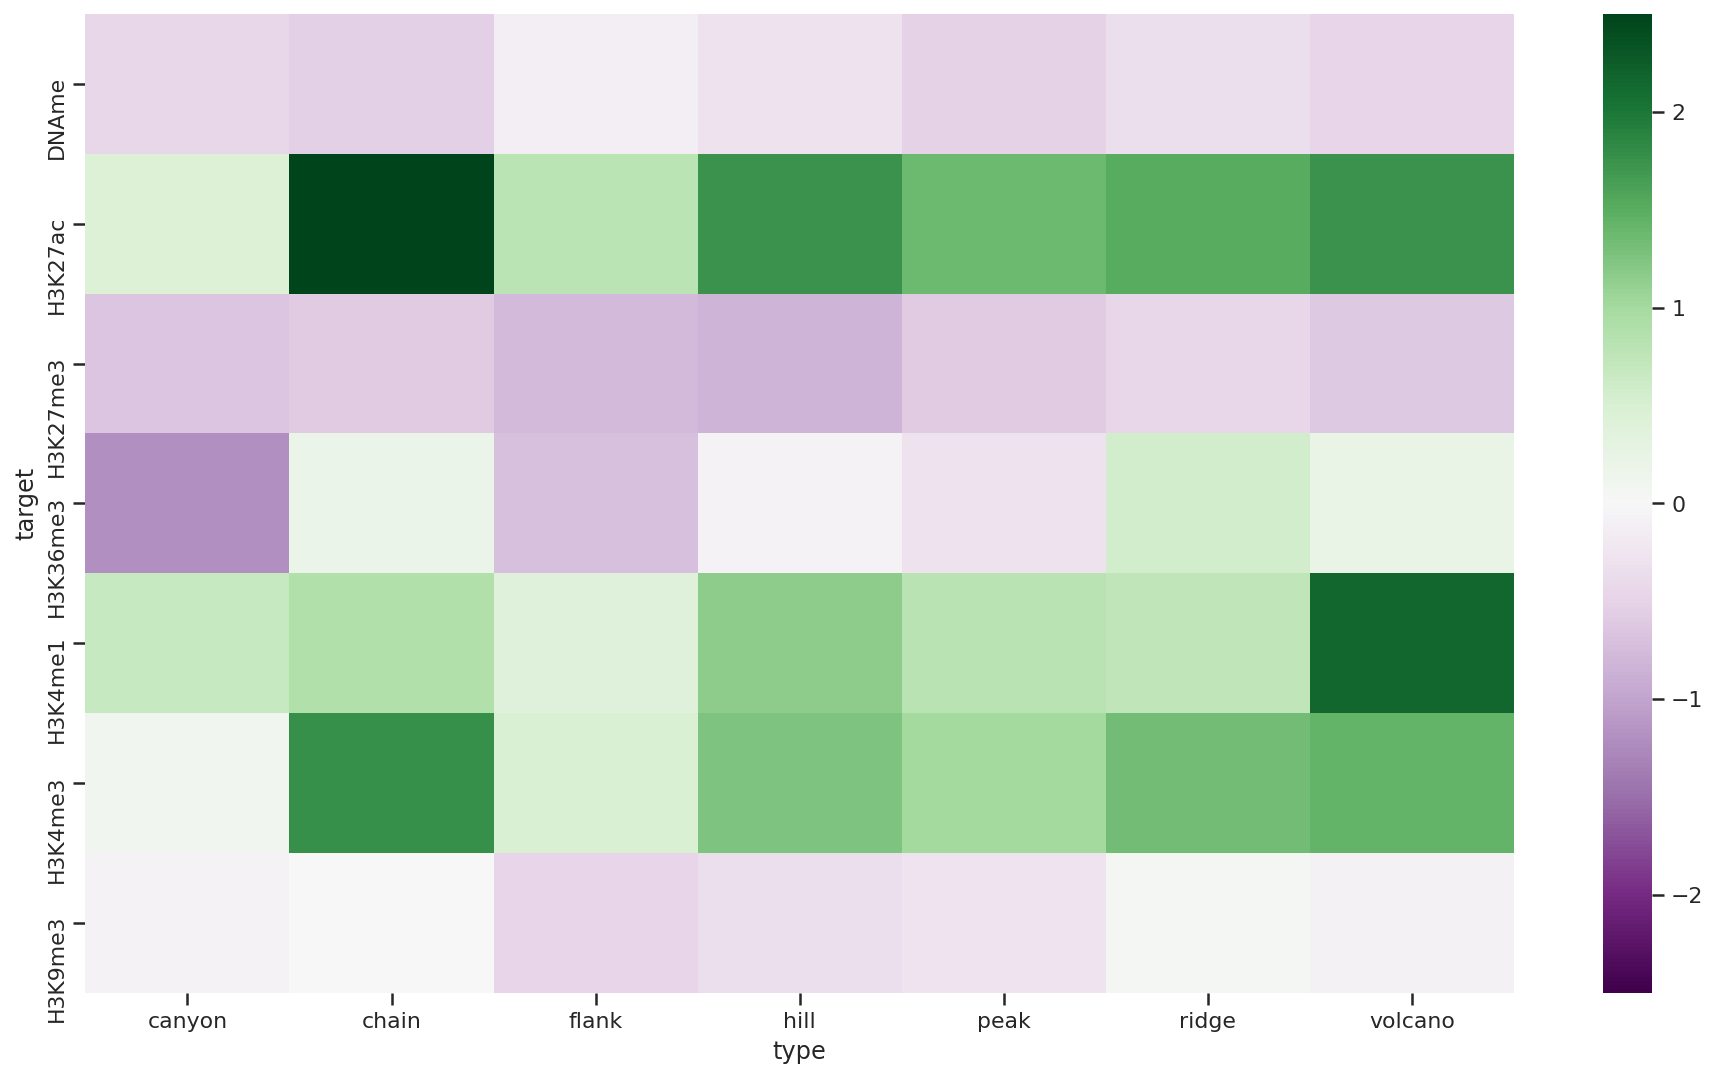

In [19]:
# Calculate the average of the fold changes across each combination of slice type and target.
all_signal_topologies_fold_change_mean = all_signal_topologies_fold_change.join(all_slicetopologies_oi[["type"]], on = "slice_ix").groupby(["type", "target"])["log_fc"].mean().unstack()
#display(all_signal_topologies_fold_change_mean)
sns.heatmap(all_signal_topologies_fold_change_mean.T, cmap = "PRGn", vmin = -2.5, vmax = 2.5)

This heatmap displays the average of the fold changes across each combination of slice type and target. As we can observe, this heatmap is relatively similar to the absolute signal. However, we can see for example that, considering the fold change, ridges don't seem to be correlated with H3K9me3 and DNAme anymore. This is probably an indication that ridges in these marks are equally present across all cell types.

### 3.2 Boxplot <a class="anchor" id="fc_bp"></a>

In [20]:
all_signal_topologies_fold_change_df = all_signal_topologies_fold_change.join(all_slicetopologies_oi[["type"]], on = "slice_ix")

<AxesSubplot:xlabel='target', ylabel='log_fc'>

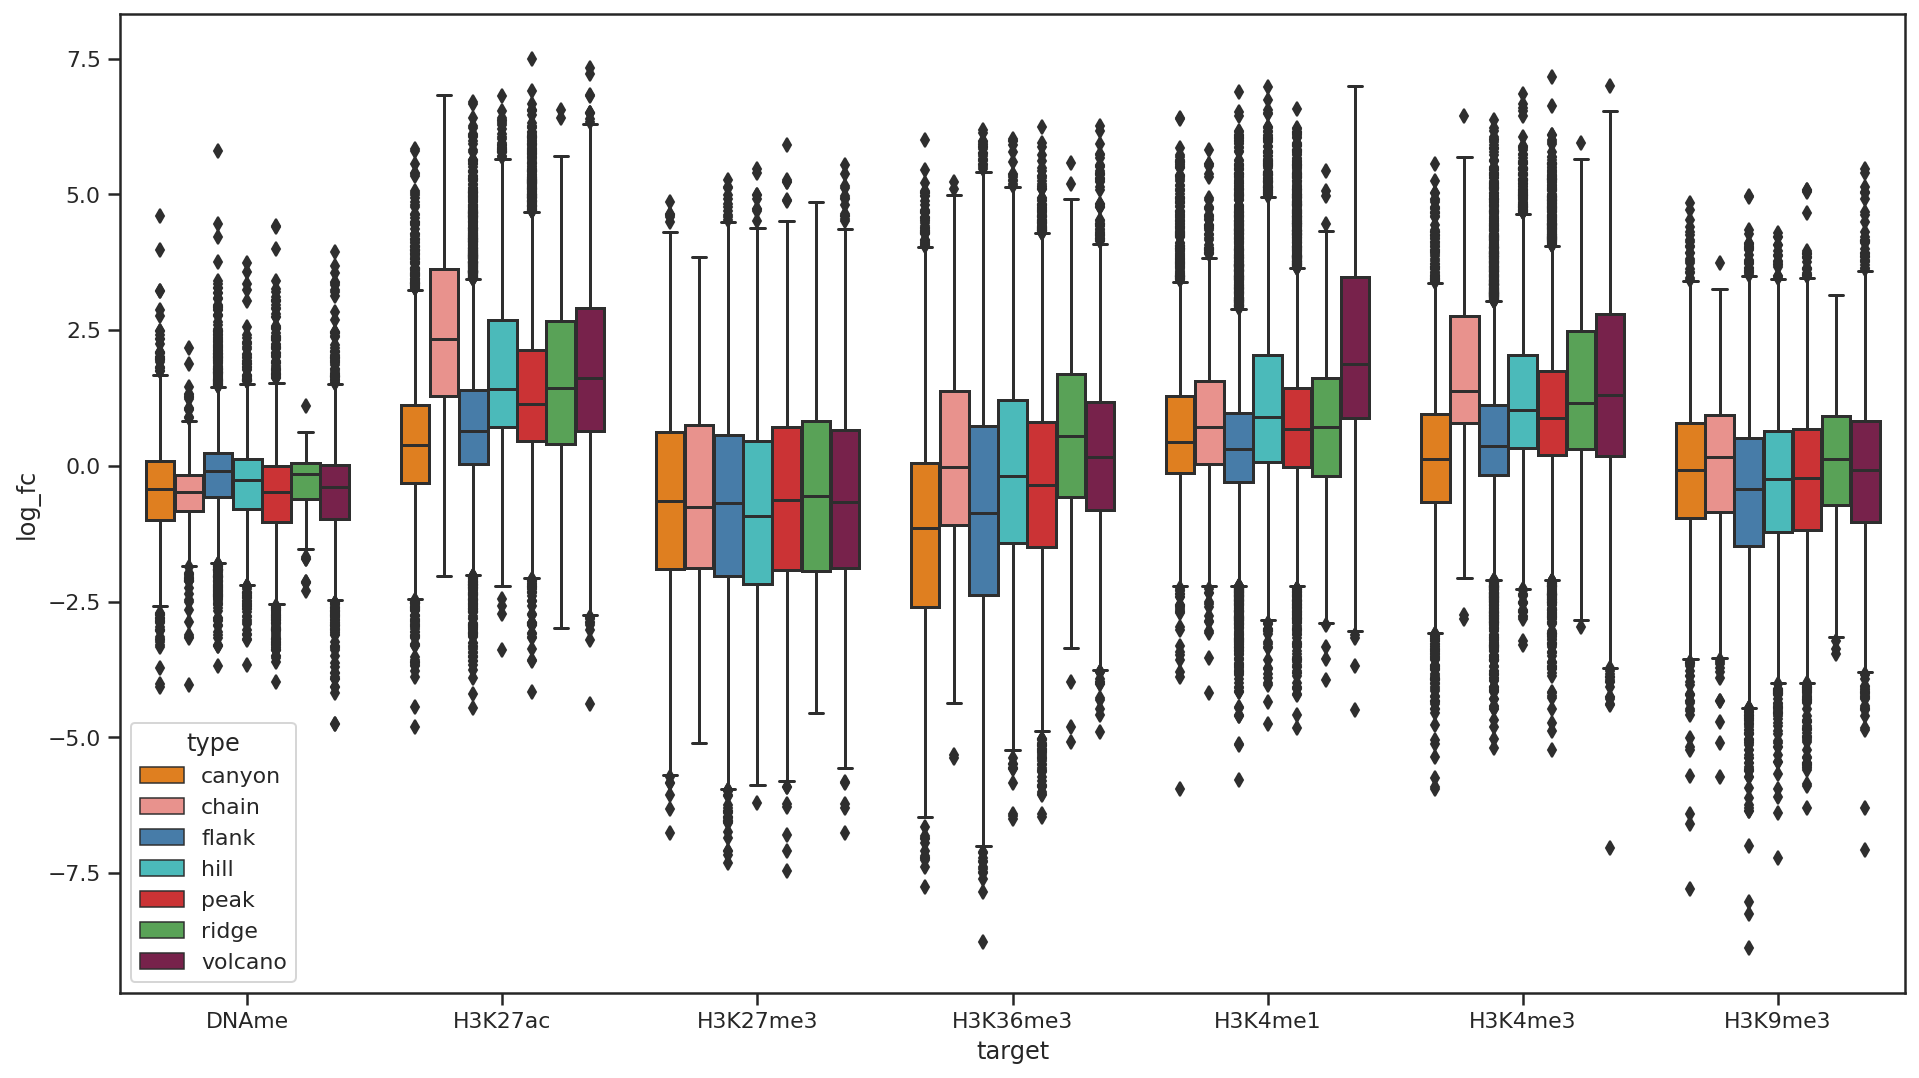

In [26]:
types = ["canyon", "chain", "flank", "hill", "peak", "ridge", "volcano"]
customPalette = sns.set_palette(sns.color_palette([chd.slicetypes.types_info.loc[type_, "color"] for type_ in types]))
        

sns.boxplot(data= all_signal_topologies_fold_change_df, x = "target", y = "log_fc", hue = "type", palette = customPalette, hue_order = types)

Here we can see the distribution of the logarithmic fold change of each topology for each target. This is another way to represent the information displayed on the previous heatmap. As we can see once again, certain topologies seem to be related to specific histone marks differentially for different cell types.

In [46]:
sig_pairs = (
    
    [("DNAme", "canyon"), ("DNAme", "flank")],
    [("DNAme", "canyon"), ("DNAme", "hill")],
    [("DNAme", "chain"),  ("DNAme", "flank")],
    [("DNAme", "chain"),  ("DNAme", "hill")],
    [("DNAme", "chain"),  ("DNAme", "ridge")],
    [("DNAme", "flank"),  ("DNAme", "hill")],
    [("DNAme", "flank"),  ("DNAme", "peak")],
    [("DNAme", "flank"),  ("DNAme", "volcano")],
    [("DNAme", "hill"),   ("DNAme", "peak")],
    [("DNAme", "hill"),   ("DNAme", "volcano")],
    
    [("H3K27ac", "canyon"), ("H3K27ac", "chain")],
    [("H3K27ac", "canyon"), ("H3K27ac", "flank")],
    [("H3K27ac", "canyon"), ("H3K27ac", "hill")],
    [("H3K27ac", "canyon"), ("H3K27ac", "peak")],
    [("H3K27ac", "canyon"), ("H3K27ac", "ridge")],
    [("H3K27ac", "canyon"), ("H3K27ac", "volcano")],
    [("H3K27ac", "chain"), ("H3K27ac", "flank")],
    [("H3K27ac", "chain"), ("H3K27ac", "hill")],
    [("H3K27ac", "chain"), ("H3K27ac", "peak")],
    [("H3K27ac", "flank"), ("H3K27ac", "volcano")],
    [("H3K27ac", "peak"), ("H3K27ac", "volcano")],
    
    [("H3K27me3", "flank"),  ("H3K27me3", "volcano")],
    
    [("H3K36me3", "canyon"), ("H3K36me3", "chain")],
    [("H3K36me3", "canyon"), ("H3K36me3", "hill")],
    [("H3K36me3", "canyon"), ("H3K36me3", "ridge")],
    [("H3K36me3", "canyon"), ("H3K36me3", "volcano")],
    [("H3K36me3", "flank"),  ("H3K36me3", "volcano")],
    [("H3K36me3", "peak"),   ("H3K36me3", "volcano")],
    
    [("H3K4me1", "canyon"), ("H3K4me1", "volcano")],
    [("H3K4me1", "chain"),  ("H3K4me1", "volcano")],
    [("H3K4me1", "flank"),  ("H3K4me1", "volcano")],
    [("H3K4me1", "hill"),   ("H3K4me1", "volcano")],
    [("H3K4me1", "peak"),   ("H3K4me1", "volcano")],
    [("H3K4me1", "ridge"),  ("H3K4me1", "volcano")],
    
    [("H3K4me3", "canyon"), ("H3K4me3", "chain")],
    [("H3K4me3", "canyon"), ("H3K4me3", "flank")],
    [("H3K4me3", "canyon"), ("H3K4me3", "hill")],
    [("H3K4me3", "canyon"), ("H3K4me3", "peak")],
    [("H3K4me3", "canyon"), ("H3K4me3", "ridge")],
    [("H3K4me3", "canyon"), ("H3K4me3", "volcano")],
    [("H3K4me3", "chain"),  ("H3K4me3", "flank")],
    [("H3K4me3", "chain"),  ("H3K4me3", "hill")],
    [("H3K4me3", "chain"),  ("H3K4me3", "peak")],
    [("H3K4me3", "flank"),  ("H3K4me3", "volcano")],
    [("H3K4me3", "hill"),   ("H3K4me3", "volcano")],
    [("H3K4me3", "peak"),   ("H3K4me3", "volcano")],
)

#### 3.2.1 Statistical significance  <a class="anchor" id="fc_ss"></a>

Here we provide t-tests for statistical significance with Bonferroni correction of the distribution of the log fold change. The resulting significant p-values are overlaid on top of the previous boxplot. We observe that, although some differences in the distributions appear to be very small, they are still statistically significant.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

H3K4me1_ridge vs. H3K4me1_volcano: t-test independent samples with Bonferroni correction, P_val:1.518e-23 t=-1.045e+01
H3K4me3_canyon vs. H3K4me3_chain: t-test independent samples with Bonferroni correction, P_val:1.776e-144 t=-2.714e+01
H3K27ac_canyon vs. H3K27ac_chain: t-test independent samples with Bonferroni correction, P_val:5.713e-242 t=-3.646e+01
DNAme_hill vs. DNAme_peak: t-test independent samples with Bonferroni correction, P_val:3.029e-07 t=5.815e+00
DNAme_chain vs. DNAme_flank: t-test independent samples with Bonferroni correction, P_val:4.840e-26 t=-1.102e+01
DNAme_flank vs. DNAme_hill: t-test independent samples with Bonferroni correction, P_val:7.178e-07 t=5.669e+00
H3K27ac_chain vs. H3K27ac_flank: t-test independent samples with Bonferroni correction, P_val:7.798e-239 t=3.435e+01
H3K36me3_ca

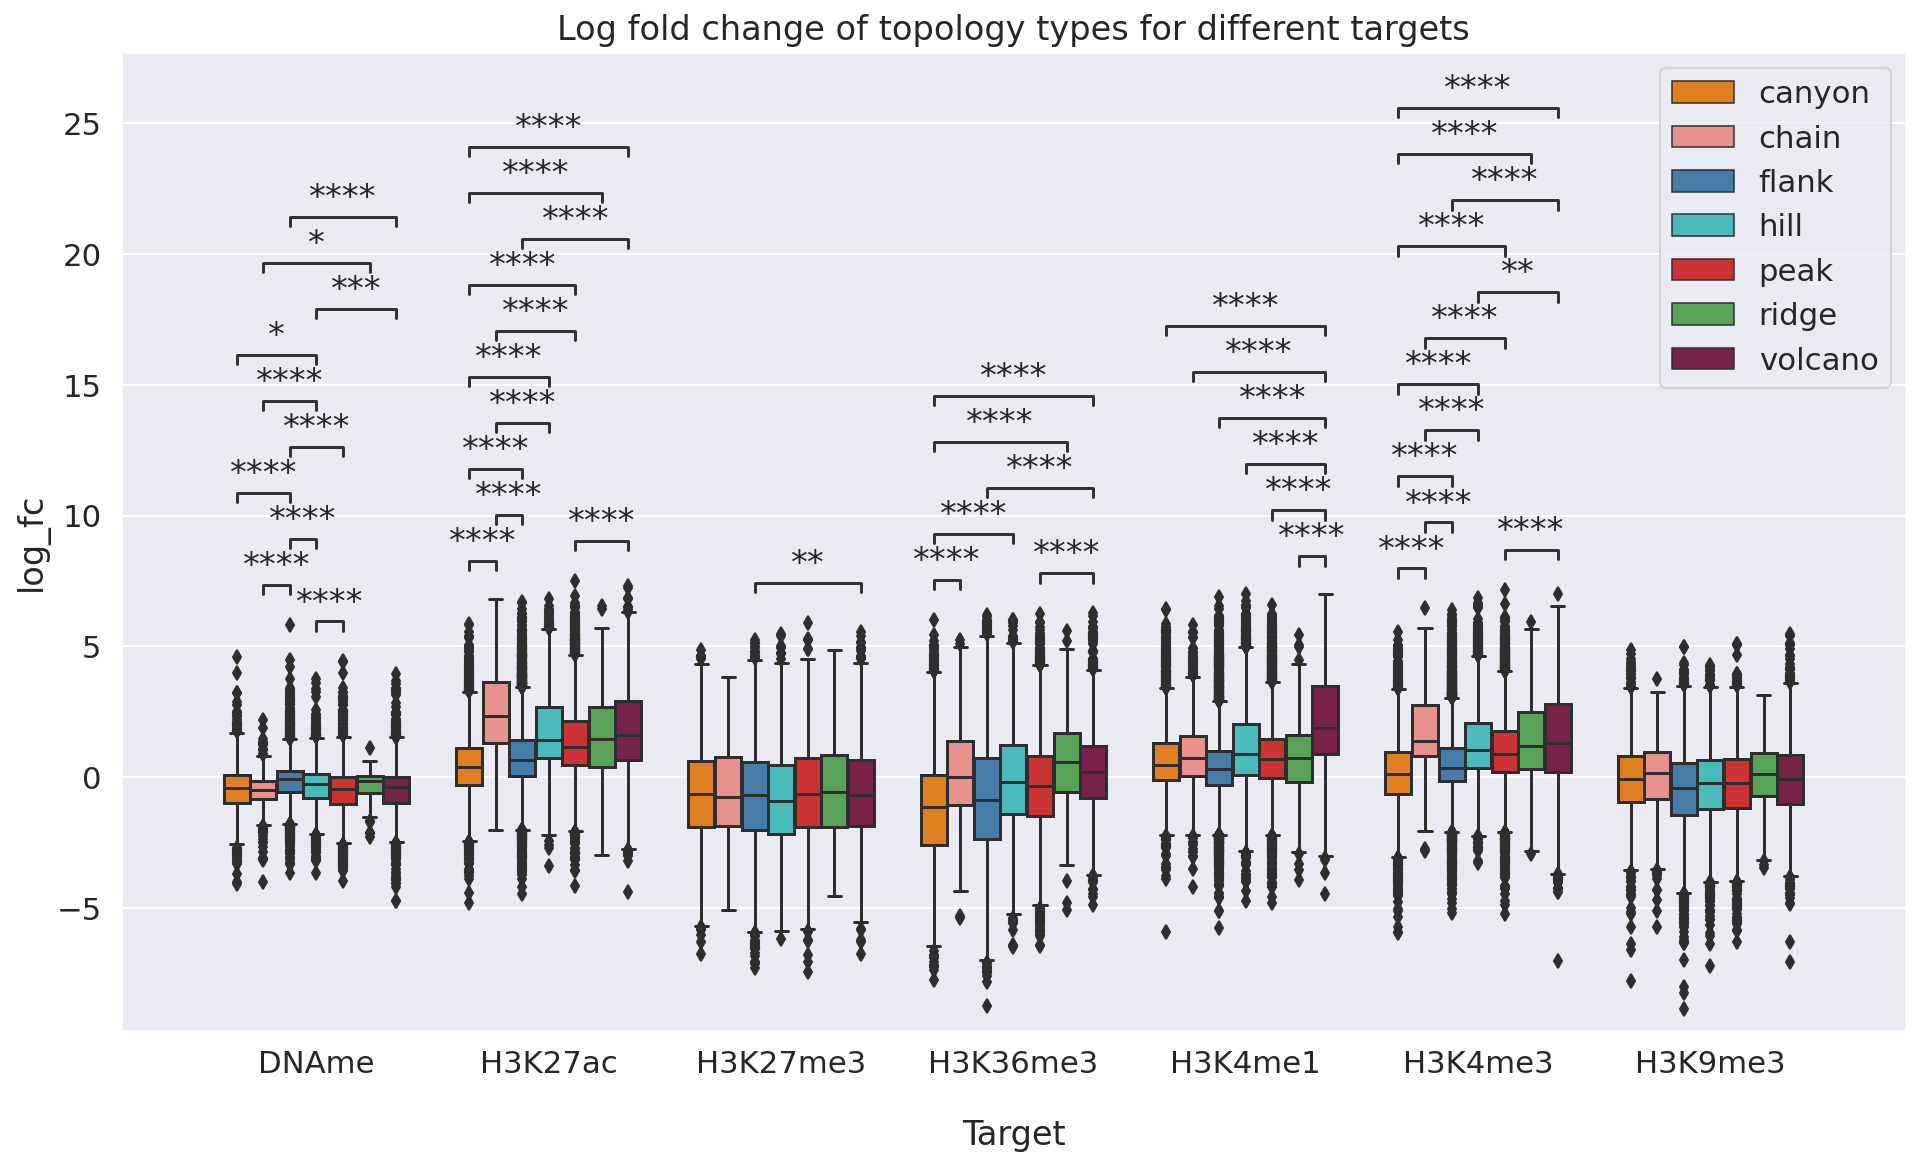

In [47]:
sns.set(rc={'figure.figsize':(16,9)})
types = ["canyon", "chain", "flank", "hill", "peak", "ridge", "volcano"]
customPalette = sns.set_palette(sns.color_palette([chd.slicetypes.types_info.loc[type_, "color"] for type_ in types]))
        

with sns.plotting_context("notebook", font_scale = 1.4):
    # Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(16,9))
    fig.patch.set_alpha(1)
    #getattr(ax, set_scale)("log")

    # Plot with seaborn
    ax = sns.boxplot(ax=ax, data= all_signal_topologies_fold_change_df, x = "target", y = "log_fc", hue = "type", palette = customPalette, hue_order = types)

    # Add annotations
    annotator = Annotator(ax, sig_pairs, data= all_signal_topologies_fold_change_df, x = "target", y = "log_fc", hue = "type", palette = customPalette, hue_order = types)
    annotator.configure(test="t-test_ind", comparisons_correction="bonferroni")
    _, corrected_results = annotator.apply_and_annotate()

    # Label and show
    ax.legend()
    plt.title("Log fold change of topology types for different targets")
    ax.set_ylabel("log_fc")
    ax.set_xlabel("Target", labelpad=20)
    plt.show()